<a href="https://colab.research.google.com/github/Ksenyff/AI/blob/main/DoE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Общие сведения о планировании эксперимента

Планирование эксперимента может рассматриваться в широком и узком значениях.

**В узлом значении планирование эксперимента (как метод, англ. design of experiments или [DoE](https://www.itl.nist.gov/div898/handbook/pri/pri.htm) method)** - это процедура выбора числа опытов и условий их проведения, необходимых для решения поставленной задачи с требуемой точностью [$^1$](http://xn--c1a3abe.xn--p1ai/book/elib2/pdf/2017/karpushkin.pdf). Основная цель планирования эксперимента — достижение максимальной точности измерений при заданном количестве проведенных опытов и сохранении статистической достоверности результатов.

**В широком смысле планирование эксперимента (как процесс)** - это структурированный подход к планированию, проведению и анализу экспериментов, позволяющий лучше понять, как множество входных переменных (факторов) влияют на выходную переменную (реакцию)[$^2$](https://www.jmp.com/en/statistics-knowledge-portal/design-of-experiments/design-of-experiments-workflow).

Планирование эксперимента как процесс включает в себя следующие шаги:
1. определение цели эксперимента (**что мы хотим получить?**)
2. выбор входных, управляемых факторов, отклика (**какие параметры системы мы задаем, меняем и исследуем?**)
3. выбор начальной математической модели (**как факторы влияют на отклик?**)
4. подбор факторов и количества экспериментов (**какие уровни факторов мы выбираем? Сколько опытов нам нужно провести? Сможем ли мы по полученным результатам построить выбранную математическую модель?**)
5. выбор средств измерения и уточнение количества экспериментов (**каким прибором мы будем изменять значения факторов, отклика? Сколько опытов необходимо провести для минимизации инструментальной погрешности прибора?**)
6. выбор средств математической обработки результатов (**как мы будем готовить и обрабатывать результаты?**)
7. описание эксперимента (**Как, где и когда будет производится эксперимент? Кто будет участвовать?**)

*Ниже мы разберем планирование эксперимента как метод, то есть затронем п.3 и п.4 экспериментального плана*

Для работы с DoE будем использовать библиотеку [pyDOE3](https://pydoe3.readthedocs.io/en/stable/index.html), позволяющую строить матрицы планирования. Библиотека реализует следующие методы:
- Факторное планирование
  * Полный факторный эксперимент
  * $2^k$ полный факторный эксперимент
  * $2^k$ дробный факторный эксперимент
  * [Метод Плакетта — Бермана](https://ru.wikipedia.org/wiki/%D0%9C%D0%B5%D1%82%D0%BE%D0%B4_%D0%9F%D0%BB%D0%B0%D0%BA%D0%B5%D1%82%D1%82%D0%B0_%E2%80%94_%D0%91%D0%B5%D1%80%D0%BC%D0%B0%D0%BD%D0%B0)
  * Планирование обобщенной выборки (англ. generalized subset design)
- Планирование поверхности отклика (англ. response surface designs)
  * Планирование Бокса-Бенкена (англ. Box-Behnken design)
  * Центрально-композиционный план (англ. central composite design)
- Рандомизированное планирование
  *  Планирование латинского гиперкуба (англ. Latin-hypercube design)
- Планирование на основе последовательностей с низким расхождением
  * Сетка Сухарева (англ. Sukharev grid)
  * Последовательность Соболя (англ. Sobol sequence)
  * Последовательность Гальтона (англ. Halton sequence)
  * Rank-1 Lattice Design
  * Последовательность Коробова (англ. Korobov sequence)
  * Рандомизация Крэнли-Паттерсона (англ. Cranley-Patterson randomization)
- Планирование Тагуши (англ. Taguchi design)
- Оптимальное планирование (англ. optimal design)

In [ ]:
!pip install pydoe3 -q

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.preprocessing import MinMaxScaler, LabelEncoder

In [ ]:
from pyDOE3 import *

In [ ]:
import math

"""
  Подготовим функцию для вывода нескольких графиков
"""
def compose_plots(designs, plot_f, cols=2, projection=None, figsize=(10, 10)):

    # Рассчитываем кол-во строк
    rows = math.ceil(len(designs) / cols)

    fig, axs = plt.subplots(rows, cols, figsize=(figsize[0], figsize[1]*rows/3), subplot_kw={'projection': projection})

    for idx, design in enumerate(designs):
        row = idx // cols
        col = idx % cols

        ax = axs[row, col] if rows > 1 else axs[col]
        plot_f(ax, design)
        ax.grid(True)

    # Скрываем пустые графики
    for idx in range(len(designs), rows*cols):
        row = idx // cols
        col = idx % cols
        axs[row, col].axis('off') if rows > 1 else axs[col].axis('off')

    plt.tight_layout()
    plt.show()

## Факторное планирование

Факторное планирование относится к планам первого порядка, то есть выполняется для построения регрессионных моделей со степенями не выше 1.

### Полный факторный эксперимент (ПФЭ)

Полный факторный эксперимент - это эксперимент, реализующий все возможные неповторяющиеся комбинации уровней независимых факторов[$^{3}$](https://portal.tpu.ru/SHARED/i/INNA/Stady/planir%20izm%20exp/Tab/%D0%93%D0%B5%D1%84%D0%B0%D0%BD%20%D0%A8%D0%B8%D1%80%D1%8F%D0%B5%D0%B2%D0%B0_%D0%9E%D1%81%D0%BD%D0%BE%D0%B2%D1%8B%20%D1%82%D0%B5%D0%BE%D1%80%D0%B8%D0%B8%20%D1%8D%D0%BA.pdf).



Определим факторы, которые будем комбинировать, для ${2^k}$ ПФЭ. Возьмем три входных фактора, влияние которых на отклик (в нашем случае точность локализации) будем исследовать:
- Минимальное количество частиц (particle_min) - категориальный фактор
- Максимальное количество частиц (particle_max) - численный фактор
- Необходимое для обновления позиции перемещение робота (update_min_d) - численный фактор

In [ ]:
factors = {
    'particle_min':["Low", "High"],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.3]
}

Для начала приведем категориальный фактор к численному виду. Используем функцию LabelEncoder() для кодирования уровней фактора числами

In [ ]:
encoder = LabelEncoder()
for factor_name in ['particle_min']:
  factors[factor_name] = np.sort(encoder.fit_transform(factors[factor_name]))

In [ ]:
factors

{'particle_min': array([0, 1]),
 'particle_max': [1000, 2000],
 'update_min_d': [0.01, 0.3]}

Используем функцию **fullfact()** для автоматического построения матрицы планирования для ПФЭ

In [ ]:
factors_levels = [len(factors[factor]) for factor in factors.keys()] # [2, 2, 2]

# на вход подадим матрицу размером 1хN
# где N - количество факторов
# значение каждой ячейки равно количеству уровней фактора
matrix = fullfact(factors_levels)

In [ ]:
print(matrix)

[[0. 0. 0.]
 [1. 0. 0.]
 [0. 1. 0.]
 [1. 1. 0.]
 [0. 0. 1.]
 [1. 0. 1.]
 [0. 1. 1.]
 [1. 1. 1.]]


Для удобной работы с данными обернем матрицу в DataFrame

In [ ]:
factors_names = factors.keys()

df = pd.DataFrame(matrix, columns=factors_names)

In [ ]:
df

,particle_min,particle_max,update_min_d
0,0.0,0.0,0.0
1,1.0,0.0,0.0
2,0.0,1.0,0.0
3,1.0,1.0,0.0
4,0.0,0.0,1.0
5,1.0,0.0,1.0
6,0.0,1.0,1.0
7,1.0,1.0,1.0


Для удобства дальнейшей работы создадим функцию, которая будет принимать на вход факторы и их значения, а выдавать таблицу планирования. Дополним нашу функцию:
* аргументом **рандомизации**, чтобы наши опыты могли проводиться в случайном
порядке
* функцией нормализации MinMax, чтобы все значения факторов были от -1 до 1

In [ ]:
def create_full_factorial_design(factors, normalize=True, randomize=False):

  # отдельно зададим количество уровней каждого фактора
  factors_levels = [len(factors[factor]) for factor in factors.keys()]

  # рассчитаем матрицу полного факторного планирования
  matrix = fullfact(factors_levels)

  if normalize:
    matrix = normalize_matrix(factors, matrix)

  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

def normalize_matrix(factors, matrix):
  # пронормализуем каждый столблец (фактор) матрицы полного факторного планирования в диапазоне [-1, 1]
  scaler = MinMaxScaler(feature_range=(-1, 1))

  # для каждого столбца (фактора)
  for i, (factor, value) in enumerate(factors.items()):

    # возьмем вычисленные уровни фактора
    ffd_levels = np.array(np.unique(matrix[:,i])).reshape(-1)

    # возьмем наши изначальные уровни
    nonscaled_levels = np.array(np.unique(np.array(factors[factor]))).reshape(-1)

    # вычислим соответствующие изначальным уровням нормализованные значения
    scaled_levels = scaler.fit_transform(nonscaled_levels.reshape(-1, 1)).reshape(-1)

    # для удобства зададим словарь соответствия вычисленного уровня фактора нормализованному
    replacement_dict = {level: scaled_level for level, scaled_level in zip(ffd_levels, scaled_levels)}

    # поменяем уровень фактора на нормализованный в заданном столбце i
    matrix[:,i] = np.array([replacement_dict.get(x) for x in matrix[:,i]])

  return matrix

In [ ]:
factors

{'particle_min': array([0, 1]),
 'particle_max': [1000, 2000],
 'update_min_d': [0.01, 0.3]}

Создадим нормализованную таблицу на базе заданных факторов

In [ ]:
design = create_full_factorial_design(factors)

In [ ]:
design

,particle_min,particle_max,update_min_d
0,-1.0,-1.0,-1.0
1,1.0,-1.0,-1.0
2,-1.0,1.0,-1.0
3,1.0,1.0,-1.0
4,-1.0,-1.0,1.0
5,1.0,-1.0,1.0
6,-1.0,1.0,1.0
7,1.0,1.0,1.0


Зададим функции для построения графиков матриц планирования в 2D и 3D.

In [ ]:
import itertools

def plot_design_matrix_2d(ax, design):
  ax.set(xlabel=design.columns[0])
  ax.set(ylabel=design.columns[1])

  x = design[design.columns[0]]
  y = design[design.columns[1]]

  ax.scatter(x, y, c='b', marker='o', s=50)

def visualize_design_matrix_2d(design):
  ax = plt.figure(figsize=(10, 10)).add_subplot(111)
  plot_design_matrix_2d(ax, design)
  plt.show()

def plot_design_matrix_3d(ax, design, as_box=True):

  ax.set(xlabel=design.columns[0])
  ax.set(ylabel=design.columns[1])
  ax.set(zlabel=design.columns[2])

  x = design[design.columns[0]]
  y = design[design.columns[1]]
  z = design[design.columns[2]]

  if as_box:
    alpha = 0.1
    constant_shape = 2, x.shape[0]
    _x, _y = np.meshgrid(x, np.linspace(y.min(), y.max(), 2))
    ax.plot_surface(_x, _y, np.ones(constant_shape)*z.min(), alpha=alpha, color='lightblue')
    ax.plot_surface(_x, _y, np.ones(constant_shape)*z.max(), alpha=alpha, color='lightblue')

    _y, _z = np.meshgrid(y, np.linspace(z.min(), z.max(), 2))
    ax.plot_surface(np.ones(constant_shape)*x.min(), _y, _z, alpha=alpha, color='lightblue')
    ax.plot_surface(np.ones(constant_shape)*x.max(), _y, _z, alpha=alpha, color='lightblue')

    _x, _z = np.meshgrid(x, np.linspace(x.min(), x.max(), 2))
    ax.plot_surface(_x, np.ones(constant_shape)*y.min(), _z, alpha=alpha, color='lightblue')
    ax.plot_surface(_x, np.ones(constant_shape)*y.max(), _z, alpha=alpha, color='lightblue')

  ax.scatter(x, y, z, c='b', marker='o', s=50)

  ax.set_box_aspect(None, zoom=0.85)

def visualize_design_matrix_3d(design, as_box=True):
  ax = plt.figure(figsize=(10, 10)).add_subplot(projection='3d')
  plot_design_matrix_3d(ax, design, as_box)
  plt.show()

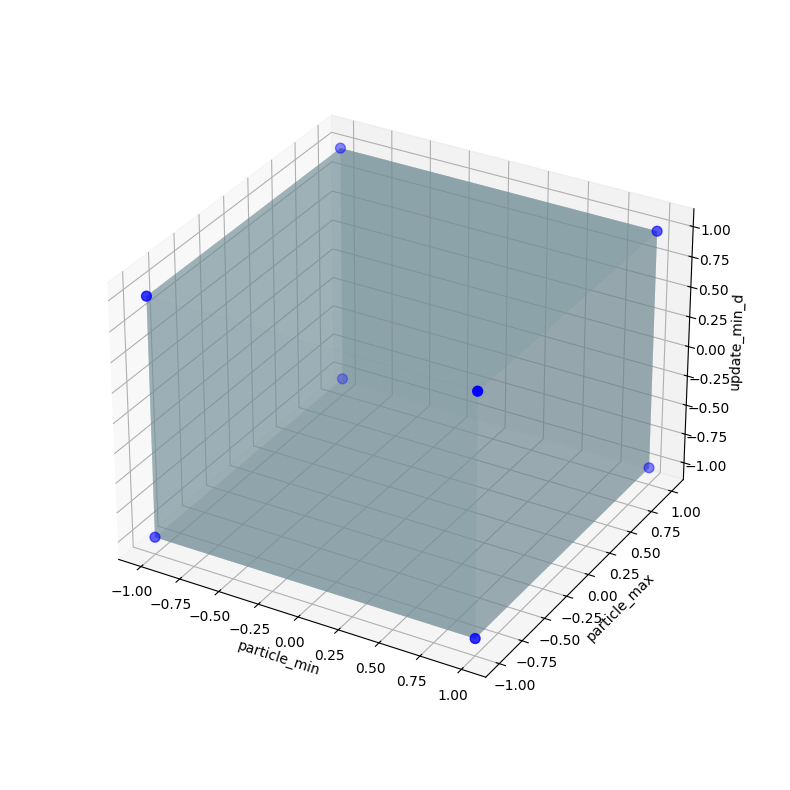

In [ ]:
visualize_design_matrix_3d(design)

In [ ]:
"""
  Построение графика воздействия факторов на отклик по отдельности
  Для 2^k полного факторного планирования
"""
def main_effects_plot(df, result_column):

    # Возьмем названия факторов из таблицы df
    factors = [col for col in df.columns if col != result_column]

    """
      Рассчитаем воздействие каждого отдельного фактора на отклик как
      суммарное среднее изменение отклика при изменении уровня фактора
    """
    main_effects = {}

    for factor in factors:
        mean_plus = df[df[factor] > 0.999][result_column].mean()
        mean_minus = df[df[factor] < -0.999][result_column].mean()
        main_effects[factor] = mean_plus - mean_minus
        if np.isnan(main_effects[factor]):
          main_effects[factor] = 0
    # Представим результаты в виде столбчатой диаграмммы
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.bar(main_effects.keys(), main_effects.values())

    # Каждый столбец диаграммы аннотируем соответствующим фактором и
    for factor, value in main_effects.items():
        ax.text(factor, value + 0.01 * abs(value), '{:.2f}'.format(value), ha='center', va='bottom')

    ax.set_ylabel('Величина воздействия')
    ax.set_title('Диаграмма воздействия каждого из факторов на отклик по отдельности')
    plt.xticks(rotation=45, ha="right")
    plt.show()

In [ ]:
import itertools
import math

"""
  Построение графика взаимодействия факторов между собой и влияния на отклик
  Для 2^k полного факторного планирования
"""
def interaction_point_plot(df, result_column):

    factors = [col for col in df.columns if col != result_column]
    interactions = list(itertools.combinations(factors, 2))

    def plot_f(ax, interaction):
        for level in [-1, 1]:

            # первый элемент пары берем константным -1 или +1
            if level == -1:
              subset = df[df[interaction[0]] < -0.999] # == -1
            else:
              subset = df[df[interaction[0]] > 0.999] # == 1

            # берем уровни фактора interaction[1] и для каждого определяем среднее значение отклика result_column
            # при фиксированном факторе interaction[0]
            ax.plot(subset[interaction[1]].unique(), subset.groupby(interaction[1])[result_column].mean(), 'o-', label=f'{interaction[0]} = {level}')
        ax.set_title(f'{interaction[0]} x {interaction[1]}')
        ax.legend()
    compose_plots(interactions, plot_f)

Сгенерируем отклик для наших факторов, для этого определим функцию f(x,y,z) и выполним вызов этой функции для всех комбинаций факторов:
$$
  f(x, y, z) = 0.5 + 0.1x  + 0.2y - 0.2z + 0.1xz
$$
где x - particle_min, y - particle_max, z - update_min_d

In [ ]:
def f(x, y, z):
  return np.round(0.5 + x * 0.1 + y * 0.2 - z * 0.1 + 0.1 * x * z, 4)

In [ ]:
design['result'] = design.apply(lambda row: f(row.particle_min, row.particle_max, row.update_min_d), axis=1)

In [ ]:
design.head()

,particle_min,particle_max,update_min_d,result
0,-1.0,-1.0,-1.0,0.4
1,1.0,-1.0,-1.0,0.4
2,-1.0,1.0,-1.0,0.8
3,1.0,1.0,-1.0,0.8
4,-1.0,-1.0,1.0,-0.0


Оценим влияние каждого из факторов на отклик системы

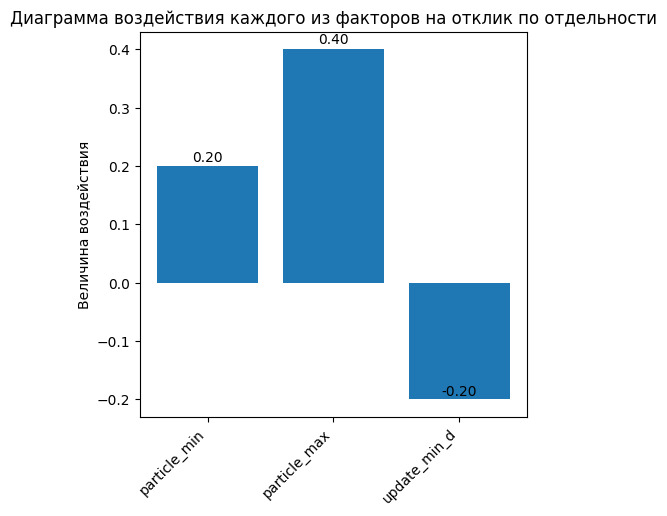

In [ ]:
main_effects_plot(design, 'result')

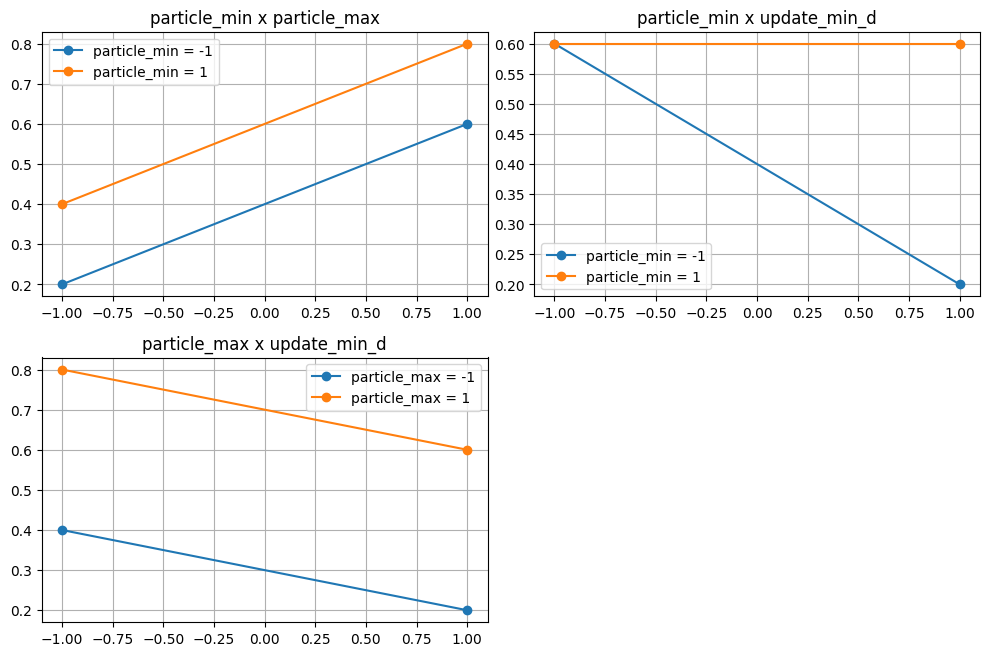

In [ ]:
interaction_point_plot(design, 'result')

В *pyDOE3* существует отдельная функция для определения $2^k$ полного факторного планирования, **ff2n(k)**, где **k** - количество факторов.

In [ ]:
k = 3
design_matrix = ff2n(k)
design_matrix

array([[-1., -1., -1.],
       [-1., -1.,  1.],
       [-1.,  1., -1.],
       [-1.,  1.,  1.],
       [ 1., -1., -1.],
       [ 1., -1.,  1.],
       [ 1.,  1., -1.],
       [ 1.,  1.,  1.]])

Заметим, что в общем случае ПФЭ позволяет работать с любым количеством факторов и их уровней

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

In [ ]:
design = create_full_factorial_design(factors)

Пространство планирования для 3х факторов, имеющих по 3 уровня, будет выглядеть следующим образом.

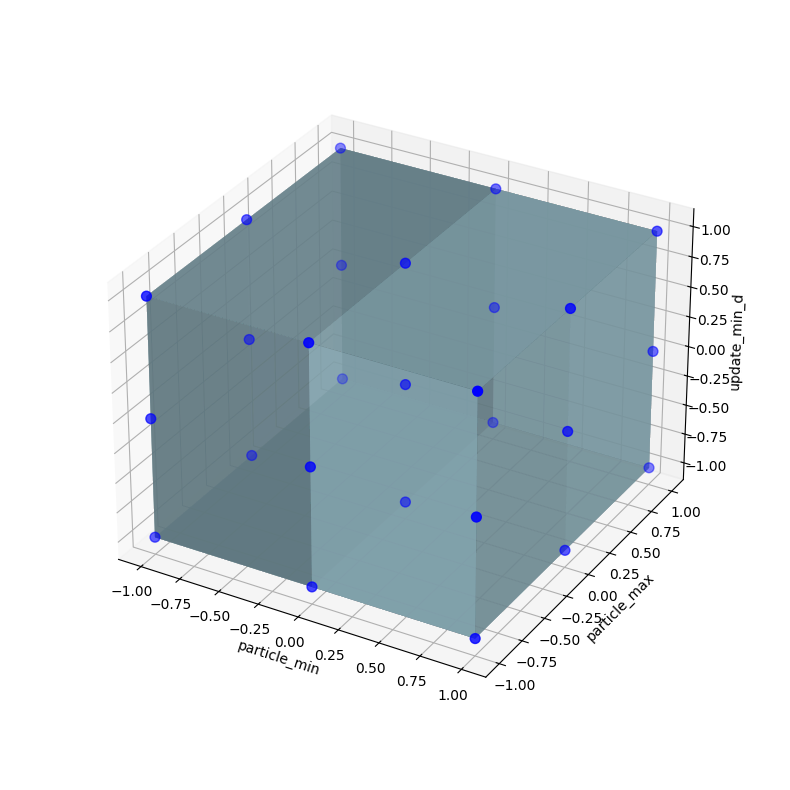

In [ ]:
visualize_design_matrix_3d(design)

Посмотрим на вид пространства относительно 2х факторов.

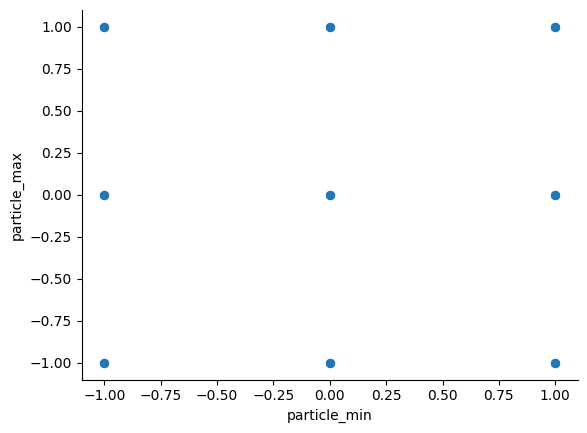

In [ ]:
design.plot(kind='scatter', x='particle_min', y='particle_max', s=32, alpha=.8)
plt.gca().spines[['top', 'right',]].set_visible(False)

Таким образом, полный факторный анализ позволяет учесть все факторы и их взаимодействия, опираясь на комбинирование всех уровней факторов со всеми.

### Дробный факторный эксперимент (ДФЭ)

Дробный факторный эксперимент - факторный эксперимент, при котором проводится неполная, то есть **дробная**, реплика полного факторного эксперимента для изучения влияния нескольких факторов на результат с меньшим числом опытов.

Для того, чтобы понять, как работает дробный факторный эксперимент, возьмем 3 фактора, каждый с 2 уровнями. Получим $2^3$ опытов для ПФЭ.

In [ ]:
factors = {
    'particle_min':[5, 60],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.3]
}
factors_levels = [len(factors[factor]) for factor in factors.keys()] # [2, 2, 2]
matrix = fullfact(factors_levels)
matrix = normalize_matrix(factors, matrix)
matrix

array([[-1., -1., -1.],
       [ 1., -1., -1.],
       [-1.,  1., -1.],
       [ 1.,  1., -1.],
       [-1., -1.,  1.],
       [ 1., -1.,  1.],
       [-1.,  1.,  1.],
       [ 1.,  1.,  1.]])

In [ ]:
matrix = np.round(matrix, 0).astype(int)

Обратим внимание, что каждый из факторов мы можем получить как произведение других двух для некоторых опытов

In [ ]:
# отобразим строки, в которых выполняется a * b = c
matrix[matrix[:,0] * matrix[:,1] == matrix[:,2]]

array([[ 1, -1, -1],
       [-1,  1, -1],
       [-1, -1,  1],
       [ 1,  1,  1]])

In [ ]:
# отобразим строки, в которых выполняется a * c = b
matrix[matrix[:,0] * matrix[:,2] == matrix[:,1]]

array([[ 1, -1, -1],
       [-1,  1, -1],
       [-1, -1,  1],
       [ 1,  1,  1]])

In [ ]:
# отобразим строки, в которых выполняется b * c = a
matrix[matrix[:,1] * matrix[:,2] == matrix[:,0]]

array([[ 1, -1, -1],
       [-1,  1, -1],
       [-1, -1,  1],
       [ 1,  1,  1]])

Заметим, что эта матрицы одинаковы

Теперь также заметим, что если мы перемножим все факторы, получим 1

In [ ]:
fract_matrix = matrix[matrix[:,1] * matrix[:,2] == matrix[:,0]]

In [ ]:
fract_matrix[:,1] * fract_matrix[:,2] * fract_matrix[:,0]

array([1, 1, 1, 1])

Таким образом, мы можем переписать уравнение
$$
  f(x,y,z) = b_0 + b_1x + b_2y + b_3z + b_4xy + b_5xz + b_6yz + b_7xyz
$$
как
$$
  f(x,y,z) = (b_0 + b_7) + (b_1+b_6)x + (b_2 + b_5)y + (b_3 + b_4)z
$$

поскольку $z=xy$, $y=xz$, $x=yz$, $xyz=1$

Упростим наше уравнение и получим уравнение с 4мя коэффициентами
$$
  f(x,y,z) = b^*_0 + b^*_1x + b^*_2y + b^*_3z
$$

Чтобы автоматически формировать такие матрицы, воспользуемся методом **fracfact()**. На вход метод принимает строку с факторами, где фактор, который мы хотим смешать с другими, представляется в виде их произведения. Например, если мы хотим представить фактор $c$ как смешение $a * b$, то пропишем его как $ab$.

In [ ]:
fracfact('a b ab')

array([[-1., -1.,  1.],
       [-1.,  1., -1.],
       [ 1., -1., -1.],
       [ 1.,  1.,  1.]])

Выполним то же самое для 4х параметров. Возьмем сначала ПФЭ.

In [ ]:
factors = {
    'particle_min':[5, 60],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.3],
    'update_min_angle':[0.1, 0.3]
}
factors_levels = [len(factors[factor]) for factor in factors.keys()] # [2, 2, 2, 2]
matrix = fullfact(factors_levels)
matrix = normalize_matrix(factors, matrix)
matrix

array([[-1., -1., -1., -1.],
       [ 1., -1., -1., -1.],
       [-1.,  1., -1., -1.],
       [ 1.,  1., -1., -1.],
       [-1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.],
       [-1.,  1.,  1., -1.],
       [ 1.,  1.,  1., -1.],
       [-1., -1., -1.,  1.],
       [ 1., -1., -1.,  1.],
       [-1.,  1., -1.,  1.],
       [ 1.,  1., -1.,  1.],
       [-1., -1.,  1.,  1.],
       [ 1., -1.,  1.,  1.],
       [-1.,  1.,  1.,  1.],
       [ 1.,  1.,  1.,  1.]])

In [ ]:
matrix = np.round(matrix, 0).astype(int)

In [ ]:
# отобразим строки, в которых выполняется a * b * c = d
matrix[matrix[:,0] * matrix[:,1] * matrix[:,2] == matrix[:,3]]

array([[-1, -1, -1, -1],
       [ 1,  1, -1, -1],
       [ 1, -1,  1, -1],
       [-1,  1,  1, -1],
       [ 1, -1, -1,  1],
       [-1,  1, -1,  1],
       [-1, -1,  1,  1],
       [ 1,  1,  1,  1]])

Можем убедиться, что для строк, для которых a * b * c = d, справедливы также 7 других ограничений

In [ ]:
design, alias_map, alias_cost = fracfact_opt(4, 1)

In [ ]:
print(f"Для планирования '{design}'\n{'\n'.join(alias_map)}")

Для планирования 'a b c abc'
a = bcd
b = acd
c = abd
d = abc
ab = cd
ac = bd
ad = bc
abcd


In [ ]:
fracfact('a b c abc')

array([[-1., -1., -1., -1.],
       [-1., -1.,  1.,  1.],
       [-1.,  1., -1.,  1.],
       [-1.,  1.,  1., -1.],
       [ 1., -1., -1.,  1.],
       [ 1., -1.,  1., -1.],
       [ 1.,  1., -1., -1.],
       [ 1.,  1.,  1.,  1.]])

Определим функцию-обертку ДФЭ в табличный вид

In [ ]:
def create_fractional_factorial_design(gen, factors, randomize=False):

  # рассчитаем матрицу полного факторного планирования
  matrix = fracfact(gen)

  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
factors

{'particle_min': [5, 60],
 'particle_max': [1000, 2000],
 'update_min_d': [0.01, 0.3],
 'update_min_angle': [0.1, 0.3]}

In [ ]:
design = create_fractional_factorial_design("a b c abc", factors)
design

,particle_min,particle_max,update_min_d,update_min_angle
0,-1.0,-1.0,-1.0,-1.0
1,-1.0,-1.0,1.0,1.0
2,-1.0,1.0,-1.0,1.0
3,-1.0,1.0,1.0,-1.0
4,1.0,-1.0,-1.0,1.0
5,1.0,-1.0,1.0,-1.0
6,1.0,1.0,-1.0,-1.0
7,1.0,1.0,1.0,1.0


In [ ]:
factors = {
    'particle_min':[5, 60],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.3],
}

In [ ]:
design = create_fractional_factorial_design("a b ab", factors)
design

,particle_min,particle_max,update_min_d
0,-1.0,-1.0,1.0
1,-1.0,1.0,-1.0
2,1.0,-1.0,-1.0
3,1.0,1.0,1.0


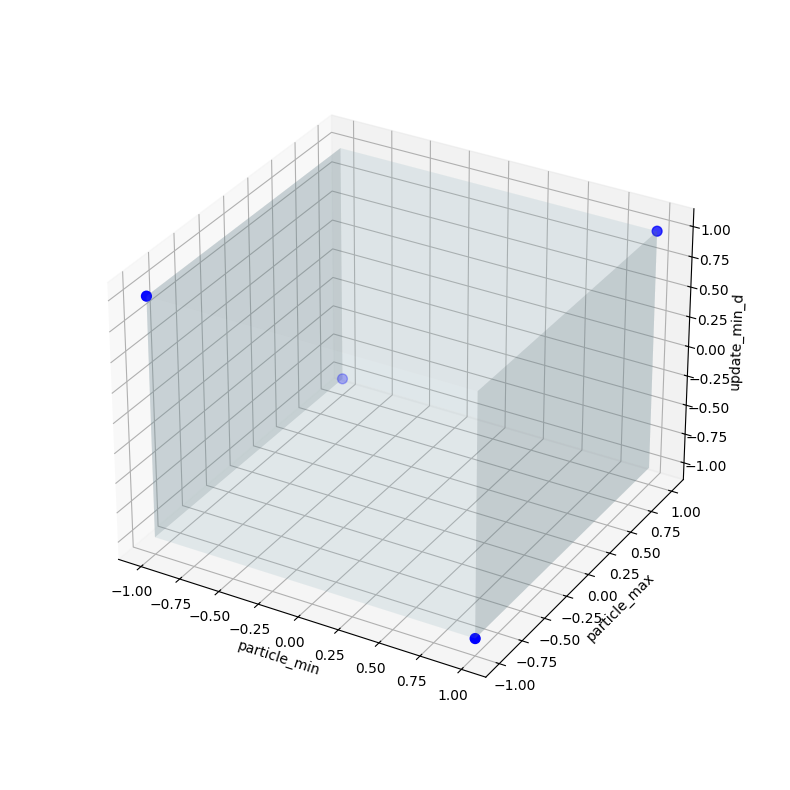

In [ ]:
visualize_design_matrix_3d(design)

### Метод Плакетта-Бермана

Метод Плакетта-Бермана - дробный факторный эксперимент с минимальным количеством опытов.

Метод генерирует минимально возможное количество опытов с учетом представления некоторых факторов как произведения других факторов. Таким образом, например, количество опытов в эксперименте из 2х и 3х факторов будет совпадать

In [ ]:
pbdesign(2).shape[0] == pbdesign(3).shape[0]

True

То же справедливо для количества факторов 4, 5, 6, 7

In [ ]:
pbdesign(4).shape[0] == pbdesign(5).shape[0] == pbdesign(6).shape[0] == pbdesign(7).shape[0]

True

In [ ]:
def create_pb_design(factors, randomize=False):

  # рассчитаем матрицу полного факторного планирования
  matrix = pbdesign(len(factors.keys()))

  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
factors = {
    'particle_min':[5, 60],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.3]
}

In [ ]:
design = create_pb_design(factors)

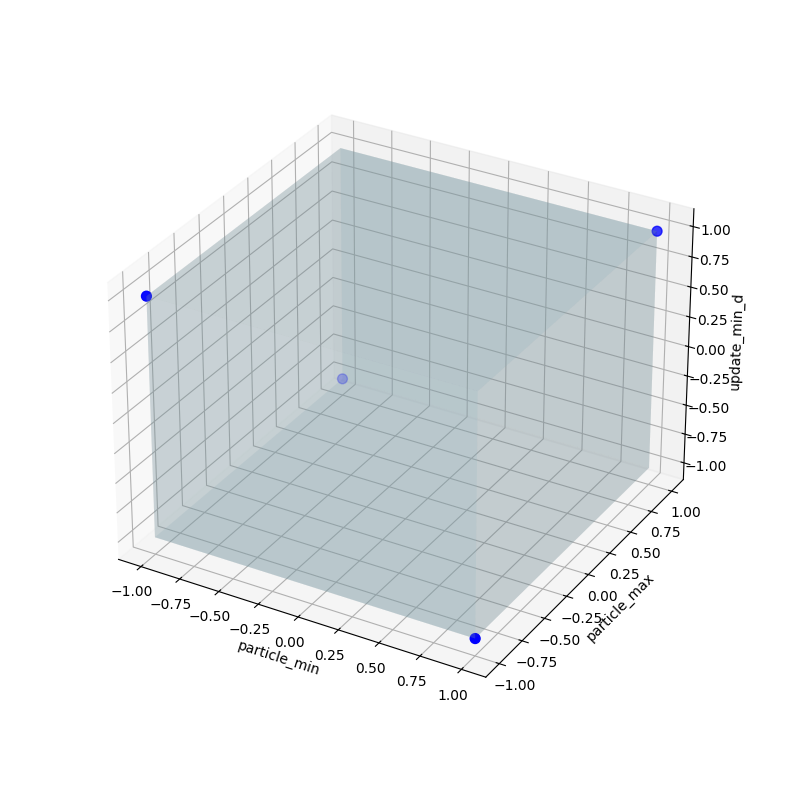

In [ ]:
visualize_design_matrix_3d(design)

### Планирование обобщенной выборки (англ. generalized subset design, сокр. GSD) [$^4$](https://pubs.acs.org/doi/pdf/10.1021/acs.analchem.7b00506?casa_token=rDfaWBwEA3IAAAAA:2-kWfUK981CEm1KtZxCTVaHGeoaIT3z76YhGwC0WMNGQseiYU519ixaW03o_egCBV4tTTeGDtDUKmH59)

Планирование обобщенной выборки - дробный факторный эксперимент для задач, в которых факторы могут иметь более двух уровней. Метод преобразовывает исходную экспериментальную матрицу в симметричные гиперкубы

Возьмем наши факторы

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

Общее количество опытов при ПФЭ будет равно произведению количества уровней каждого из факторов

In [ ]:
factors_levels = [len(factors[factor]) for factor in factors.keys()] # [2, 2, 2]

print("Общее количество опытов:", np.prod(factors_levels))

Общее количество опытов: 27


Уменьшим количество опытов, использовав GSD и указав, во сколько раз необходимо уменьшить количество опытов

In [ ]:
reduction = 2 # уменьшим количество опытов в 2 раза
design_matrix = gsd(factors_levels, reduction)

print("Количество опытов:", design_matrix.shape[0])

Количество опытов: 14


In [ ]:
design_matrix

array([[0, 0, 0],
       [0, 0, 2],
       [0, 2, 0],
       [0, 2, 2],
       [2, 0, 0],
       [2, 0, 2],
       [2, 2, 0],
       [2, 2, 2],
       [0, 1, 1],
       [2, 1, 1],
       [1, 0, 1],
       [1, 2, 1],
       [1, 1, 0],
       [1, 1, 2]])

In [ ]:
def create_gsd(factors, reduction=2, randomize=False):

  factors_levels = [len(factors[factor]) for factor in factors.keys()]

  # рассчитаем матрицу полного факторного планирования
  matrix = gsd(factors_levels, reduction)

  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

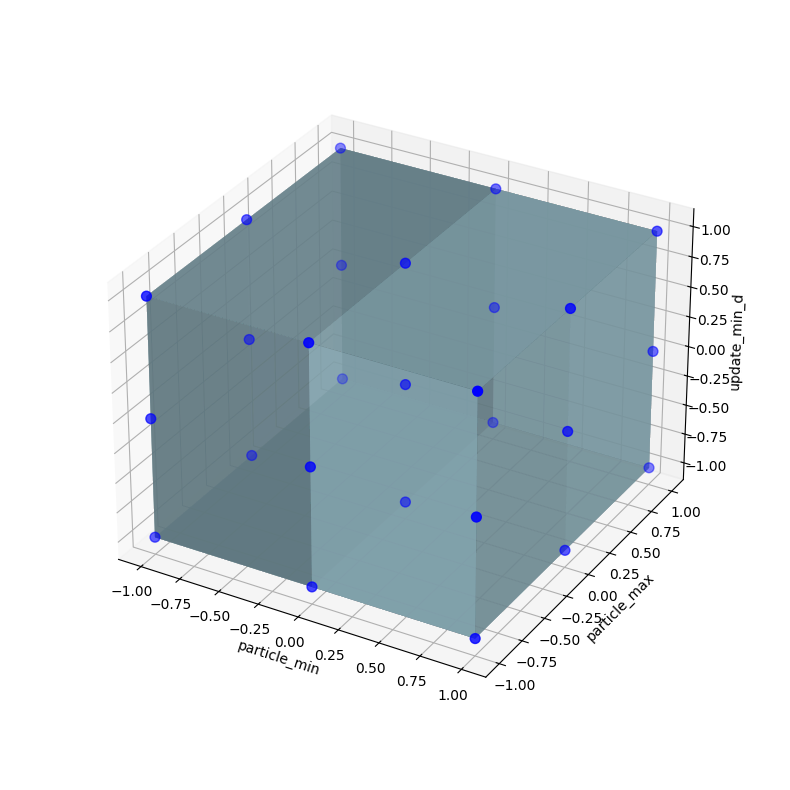

In [ ]:
design = create_full_factorial_design(factors)
visualize_design_matrix_3d(design)

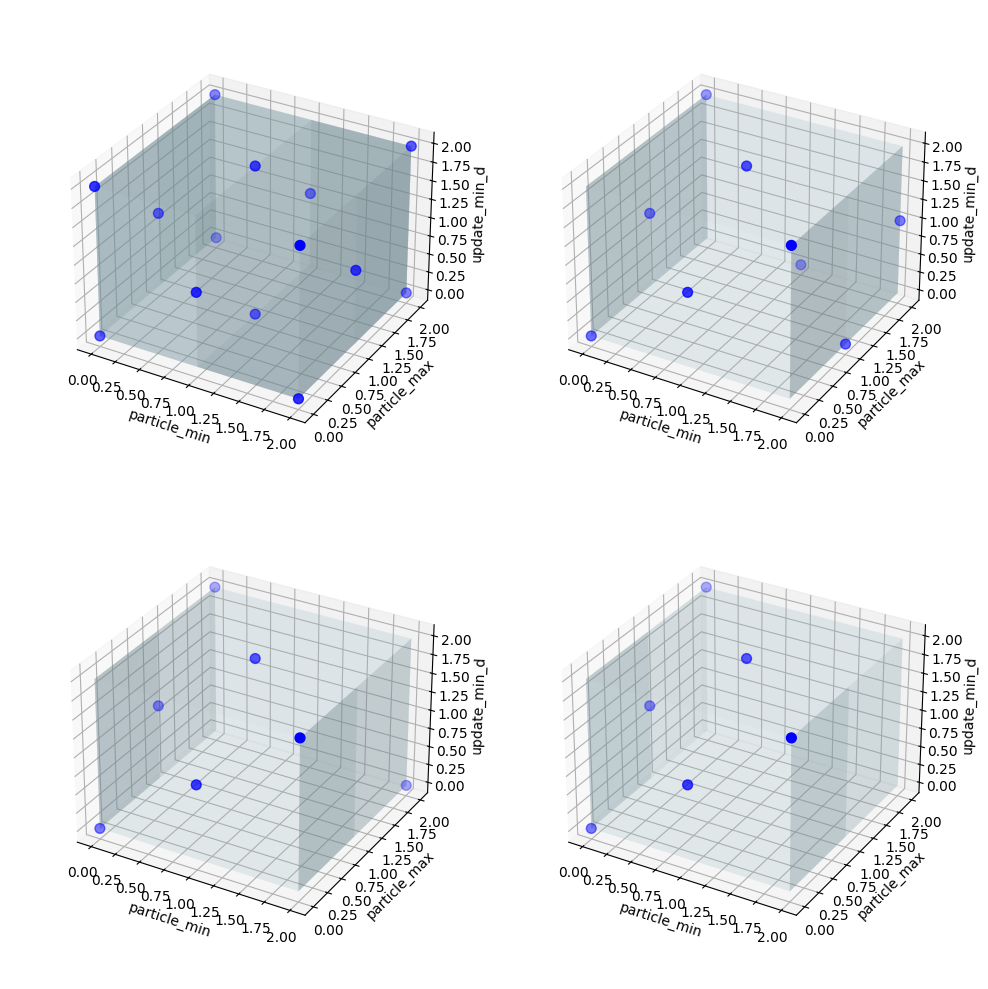

In [ ]:
designs = []
for reduction in range(2, 6):
  designs.append(create_gsd(factors, reduction=reduction))
compose_plots(designs, plot_design_matrix_3d, cols=2, projection="3d", figsize=(10, 15))

## Планирование поверхности отклика (англ. response surface designs)

Планирование поверхности отклика - метод планирования эксперимента, предлагающий использовать полиномиальную модель второй степени в качестве целевой модели

### Планирование Бокса-Бенкена (англ. Box-Behnken design)

Планирование Бокса-Бенкена включает три уровня для каждого фактора (-1, 0, +1). Основная идея - комбинирование среднего уровня одного из факторов с экстремальными значениями остальных факторов

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

In [ ]:
def create_bb_design(factors, center_points_count=1, randomize=False):

  factors_number = len(factors.keys())

  # рассчитаем матрицу полного факторного планирования
  matrix = bbdesign(factors_number, center_points_count)

  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
design = create_bb_design(factors)

In [ ]:
design

,particle_min,particle_max,update_min_d
0,-1.0,-1.0,0.0
1,-1.0,1.0,0.0
2,1.0,-1.0,0.0
3,1.0,1.0,0.0
4,-1.0,0.0,-1.0
5,-1.0,0.0,1.0
6,1.0,0.0,-1.0
7,1.0,0.0,1.0
8,0.0,-1.0,-1.0
9,0.0,-1.0,1.0


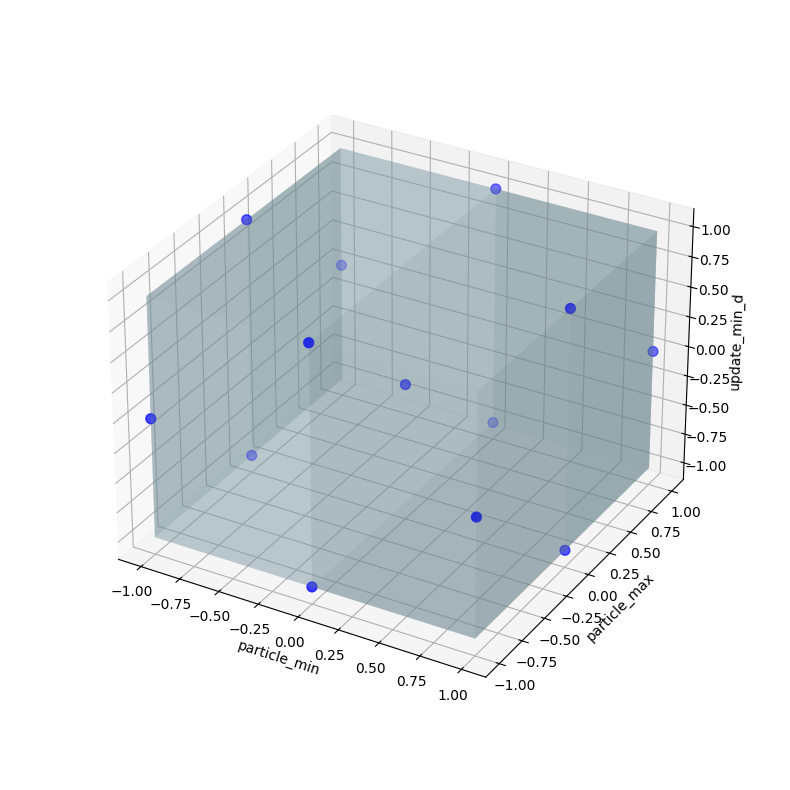

In [ ]:
visualize_design_matrix_3d(design)

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19],
    'update_min_angle':[0.1, 0.2, 0.3]
}

In [ ]:
design = create_bb_design(factors)

In [ ]:
design

,particle_min,particle_max,update_min_d,update_min_angle
0,-1.0,-1.0,0.0,0.0
1,-1.0,1.0,0.0,0.0
2,1.0,-1.0,0.0,0.0
3,1.0,1.0,0.0,0.0
4,-1.0,0.0,-1.0,0.0
5,-1.0,0.0,1.0,0.0
6,1.0,0.0,-1.0,0.0
7,1.0,0.0,1.0,0.0
8,-1.0,0.0,0.0,-1.0
9,-1.0,0.0,0.0,1.0


### Центрально-композиционное планирование (англ. central composite design)

Центрально-композиционное планирование - метод математического планирования эксперимента, который используется для построения поверхностей отклика и определения оптимальных условий в многофакторных системах, где требуется исследовать нелинейные зависимости между факторами и выходными параметрами.

Основная идея метода - построение матрицы планирования вокруг некоторого центра.
Построение может выполняться тремя способами: описываться  а) в виде окружности, ограниченной экстремальными значениями, с вписанным квадратом (inscribed), б) в виде квадрата, ограниченного экстремальными значениями (faced), в)  в виде окружности, с вписанным квадратом, ограниченным экстремальными значениями (circumscribed)


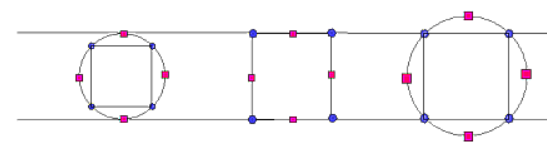

In [ ]:
def create_cc_design(factors, center_point=(4,4), face="faced", randomize=False):

  factors_number = len(factors.keys())
  matrix = ccdesign(factors_number, center=center_point, face=face)
  df = pd.DataFrame(matrix, columns=factors.keys())

  if randomize:
      df = df.sample(frac=1).reset_index(drop=True)

  return df

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000]
}

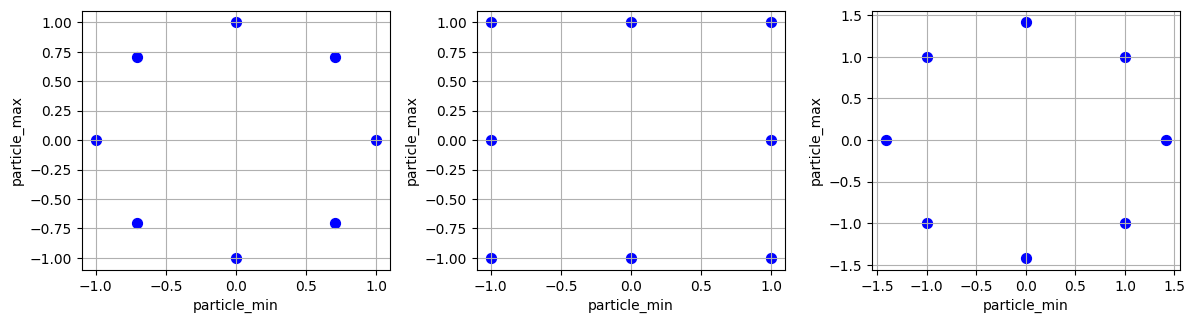

In [ ]:
designs = []
for face in ["inscribed", "faced", "circumscribed"]:
  designs.append(create_cc_design(factors, center_point=(0, 0), face=face))
compose_plots(designs, plot_design_matrix_2d, cols=3, figsize=(12, 10))

## Рандомизированное планирование

Рандомизированное планирование - подбор факторов из некоторого распределения

### Планирование латинского гиперкуба (англ. Latin-hypercube design)

Выборка методом латинского гиперкуба - это статистический метод генерации почти случайной выборки значений параметров из многомерного распределения

In [ ]:
def create_lhd(factors, samples=5):

  factors_number = len(factors.keys())
  matrix = lhs(factors_number, samples=samples)
  df = pd.DataFrame(matrix, columns=factors.keys())

  return df

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000]
}

In [ ]:
design = create_lhd(factors, samples=100)

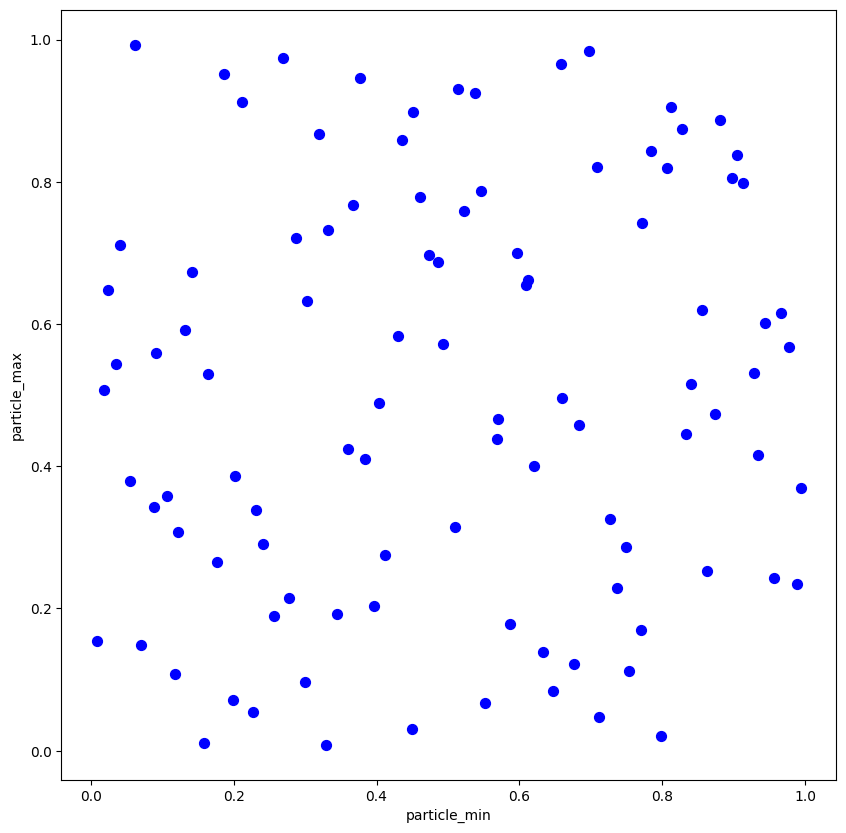

In [ ]:
visualize_design_matrix_2d(design)

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

In [ ]:
design = create_lhd(factors, samples=100)

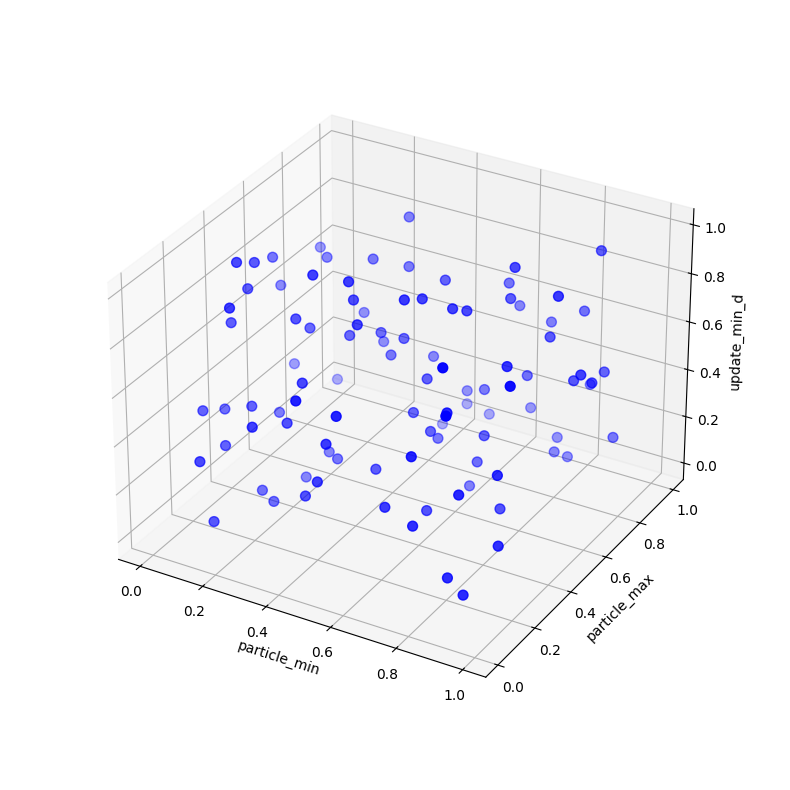

In [ ]:
visualize_design_matrix_3d(design, as_box=False)

## Планирование на основе последовательностей с низким расхождением [$^5$](https://ru.wikipedia.org/wiki/%D0%9F%D0%BE%D1%81%D0%BB%D0%B5%D0%B4%D0%BE%D0%B2%D0%B0%D1%82%D0%B5%D0%BB%D1%8C%D0%BD%D0%BE%D1%81%D1%82%D1%8C_%D1%81_%D0%BD%D0%B8%D0%B7%D0%BA%D0%B8%D0%BC_%D1%80%D0%B0%D1%81%D1%85%D0%BE%D0%B6%D0%B4%D0%B5%D0%BD%D0%B8%D0%B5%D0%BC)

Планирование на основе последовательностей с низким расхождением - планирование эксперимента, генерирующее матрицу планирования на основе квазислучайных последовательностей. Такие последовательности стремятся к равномерному заполнению пространства.

### Сетка Сухарева (англ. Sukharev grid)

Сетка Сухарева - это детерминированное планирование с низким уровнем расхождений, которое размещает точки в центрах ячеек одинакового размера в единичном гиперкубе. В отличие от случайной выборки, точки не располагаются на границах.

In [ ]:
def create_sukharev_grid(factors, samples=5):

  factors_number = len(factors.keys())
  matrix = sukharev_grid(samples, factors_number)
  df = pd.DataFrame(matrix, columns=factors.keys())

  return df

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000]
}

In [ ]:
factors_number = len(factors.keys())
available_sample_values = [i ** factors_number for i in range(2,10)]
print("Допустимые значения количества точек:", available_sample_values)

Допустимые значения количества точек: [4, 9, 16, 25, 36, 49, 64, 81]


In [ ]:
design = create_sukharev_grid(factors, samples=36)

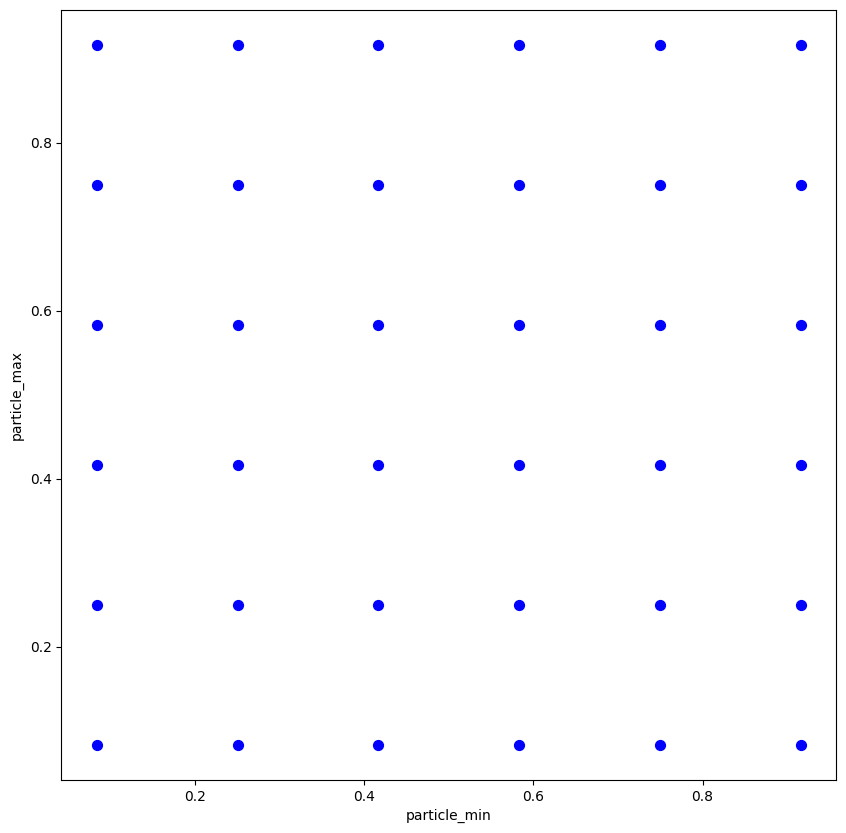

In [ ]:
visualize_design_matrix_2d(design)

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

In [ ]:
factors_number = len(factors.keys())
available_sample_values = [i ** factors_number for i in range(2,10)]
print("Допустимые значения количества точек:", available_sample_values)

Допустимые значения количества точек: [8, 27, 64, 125, 216, 343, 512, 729]


In [ ]:
def sukharev_grid(num_points, dimension):
    """Create Sukharev grid in unit hypercube.

    Special property of this grid is that points are not placed on the
    boundaries of the hypercube, but at centroids of the `num_points`
    subcells. This design offers optimal results for the covering radius
    regarding distances based on the max-norm.

    Parameters
    ----------
    num_points : int
        The number of points to generate.
        ``num_points ** (1/dimension)`` must be integer.
    dimension : int
        The dimension of the space.

    Returns
    -------
    points : (`num_points`, `dimension`) numpy array

    """
    points_per_axis = int(np.round(num_points ** (1.0 / dimension)))
    assert points_per_axis**dimension == num_points
    possible_values = [x + 0.5 for x in range(points_per_axis)]
    divisor = points_per_axis
    for i in range(points_per_axis):
        possible_values[i] /= divisor
    points = np.array(list(itertools.product(possible_values, repeat=dimension)))

    return points

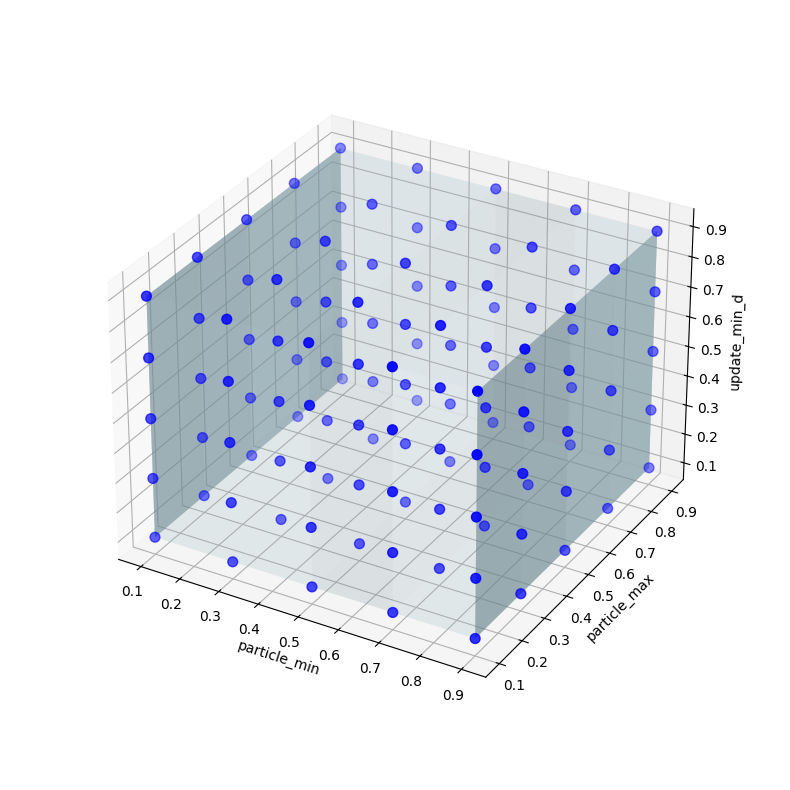

In [ ]:
design = create_sukharev_grid(factors, samples=125)
visualize_design_matrix_3d(design, as_box=True)

### Последовательность Соболя (англ. Sobol sequence)

Последовательности Соболя - это очень однородные последовательности с низким уровнем расхождений, обычно используемые в численных методах и количественной оценке неопределенности.

In [ ]:
def create_sobol(factors, samples=5):

  factors_number = len(factors.keys())
  matrix = sobol_sequence(samples, factors_number, scramble=False, bounds=None, seed=None)
  df = pd.DataFrame(matrix, columns=factors.keys())

  return df

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000]
}

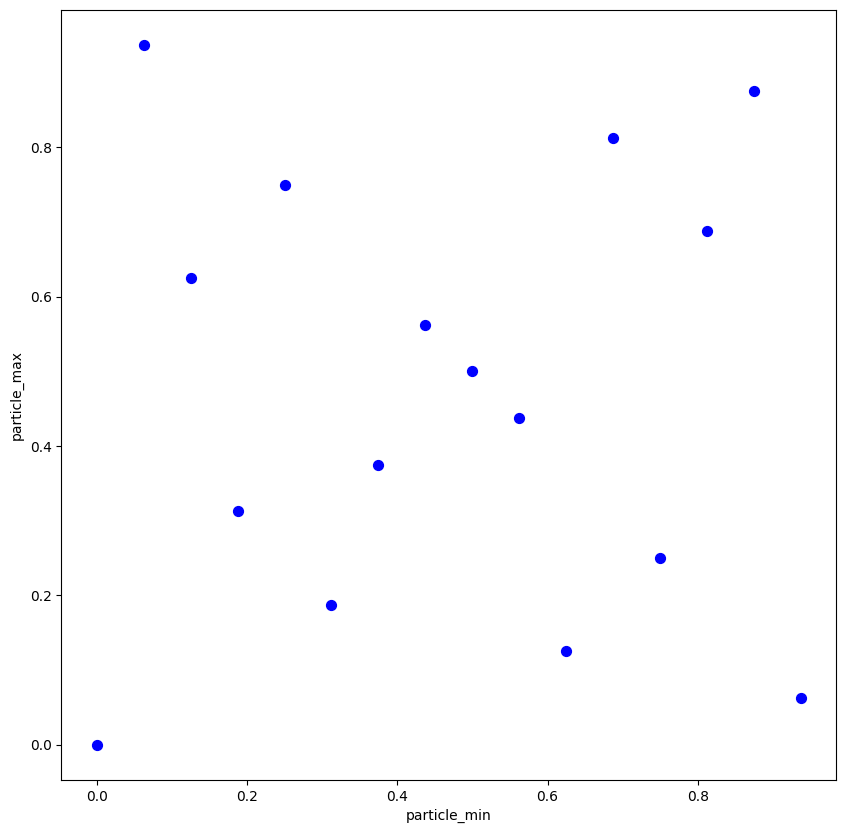

In [ ]:
design = create_sobol(factors, samples=10)
visualize_design_matrix_2d(design)

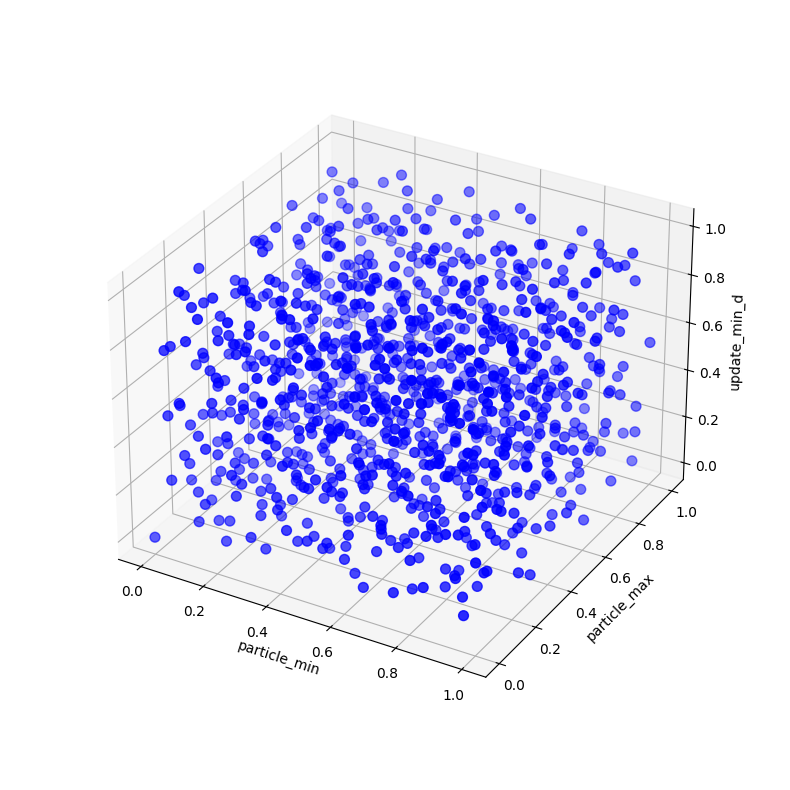

In [ ]:
factors = {
    'particle_min':[5, 30, 55],
    'particle_max':[1000, 1500, 2000],
    'update_min_d':[0.01, 0.1, 0.19]
}

design = create_sobol(factors, samples=1000)
visualize_design_matrix_3d(design, as_box=False)

## Планирование Тагучи (англ. Taguchi design)



Планы Тагучи можно получить, выполнив **list_orthogonal_arrays()**. Нотация L4 означает, что производится 4 опыта. (2^3) означает, что матрица планирования разработана для 3 факторов с 2 уровнями каждый.

In [ ]:
list_orthogonal_arrays()

['L4(2^3)',
 'L8(2^7)',
 'L9(3^4)',
 'L12(2^11)',
 'L16(2^15)',
 'L16(4^5)',
 'L18(6^1 3^6)',
 'L25(5^6)',
 'L27(2^1 3^12)',
 'L32(2^31)',
 'L32(2^1 4^9)',
 'L36(3^23)',
 'L50(2^1 5^11)',
 'L54(2^1 3^25)',
 'L64(2^31)',
 'L64(4^21)',
 'L81(3^40)']

Возьмем матрицу планирования для 4 факторов с 3 уровнями.

In [ ]:
get_orthogonal_array('L9(3^4)')

array([[0, 0, 0, 0],
       [0, 1, 1, 1],
       [0, 2, 2, 2],
       [1, 0, 1, 2],
       [1, 1, 2, 0],
       [1, 2, 0, 1],
       [2, 0, 2, 1],
       [2, 1, 0, 2],
       [2, 2, 1, 0]])

In [ ]:
def create_taguchi(factors, plan):

  matrix = get_orthogonal_array(plan)
  df = pd.DataFrame(matrix, columns=factors.keys())

  return df

In [ ]:
factors = {
    'particle_min':[5,  55],
    'particle_max':[1000, 2000],
    'update_min_d':[0.01, 0.19],
}

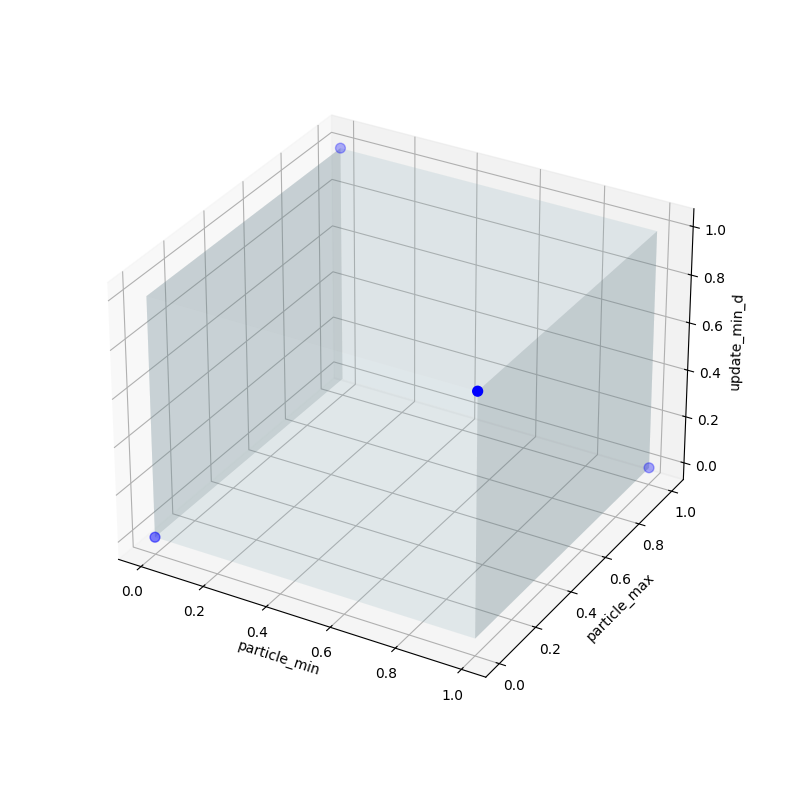

In [ ]:
design = create_taguchi(factors, 'L4(2^3)')
visualize_design_matrix_3d(design)

## Последовательность использования методов

Описанные методы имеют различные приложения в решении задачи подбора наиболее важных факторов и построении регрессионной модели изучаемой системы.

Стоит выделить 3 основных вида:
1. Обзорное планирование - изучение различных уровней всех возможных факторов
- Рандомизированное планирование
- Планирование на основе последовательностей с низким расхождением
2. Отсеивающее планирование - изучение влияния факторов друг на друга и на отклик
- Дробный факторный эксперимент и его разновидности
3. Оптимизационное планирование - построение регресионной модели на основе наиболее важных факторов
- Планирование поверхности отклика

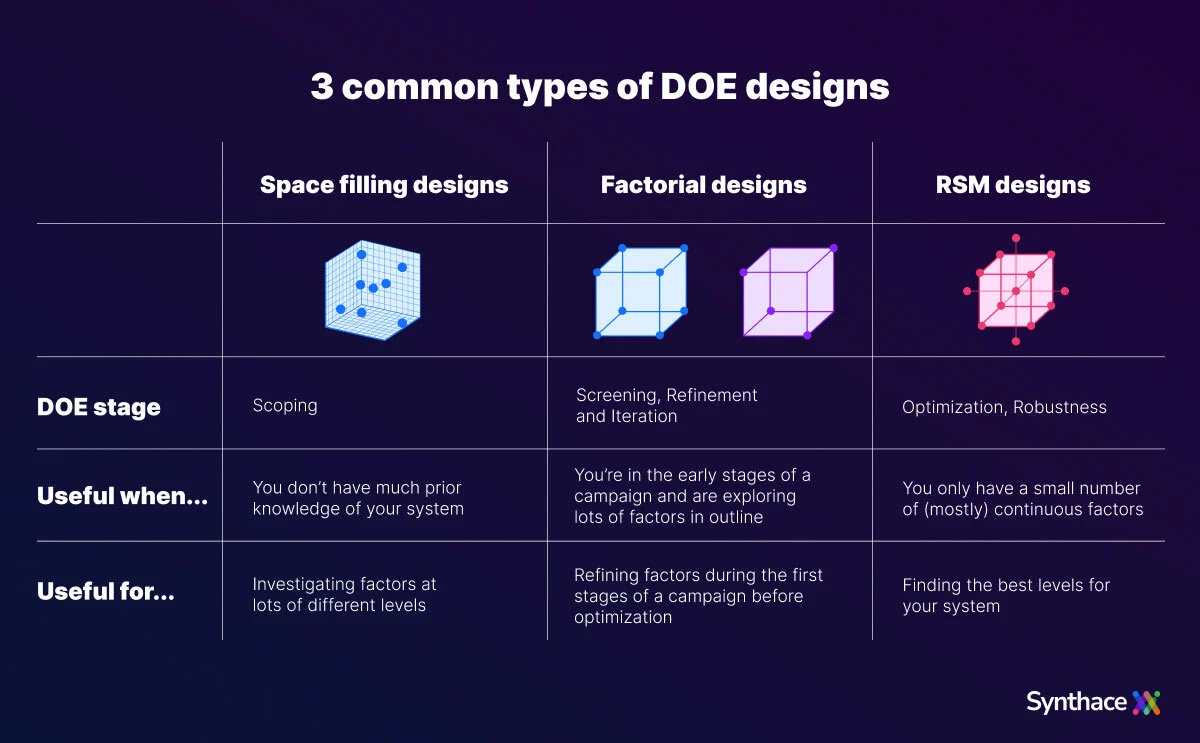

Рисунок 1 - [Типы DoE планирований](https://www.synthace.com/blog/types-of-doe-design-a-users-guide)

## Материалы

- [Full factorial design in Python from Beginning to End](https://www.experimentaldesignhub.com/blog/example-of-a-full-factorial-design-in-python)
- [NIST DoE Handbook](https://www.itl.nist.gov/div898/handbook/pri/pri.htm)